In [1]:
import tensorflow as tf

In [42]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import tensorflow_hub as hub
import os

In [45]:
TOP_PATH = os.environ['PWD']

In [3]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [4]:
tf.keras.backend.clear_session()

In [5]:
content_path = tf.keras.utils.get_file('marilyn.jpg', 'https://www.moma.org/learn/moma_learning/_assets/www.moma.org/wp/moma_learning/wp-content/uploads/2012/07/Marilyn-PhotoPortrait-332x395.jpg')
style_path_1 = tf.keras.utils.get_file('spiderverse.jpg','https://m.media-amazon.com/images/M/MV5BMTU4NjYwNzAxN15BMl5BanBnXkFtZTgwMDkyODI4NjM@._V1_SX1777_CR0,0,1777,744_AL_.jpg')
style_path_2 = tf.keras.utils.get_file('matrix.jpg','https://m.media-amazon.com/images/M/MV5BMGM1NTk4YjMtNWNkNi00MzY3LWI3OTUtNTdmZGI3NmU2MGI0XkEyXkFqcGdeQXVyOTY2MDM3MjM@._V1_SX1777_CR0,0,1777,728_AL_.jpg')
style_path_3 = tf.keras.utils.get_file('frozen.jpg','https://m.media-amazon.com/images/M/MV5BYTk2MzNmZDAtODg5NC00OGYwLWE5MGMtNzc2NTM4ODQzYWZiXkEyXkFqcGdeQXVyNjQ4ODE4MzQ@._V1_SX1777_CR0,0,1777,740_AL_.jpg')
style_path_4 = tf.keras.utils.get_file('grandbudapest.jpg','https://m.media-amazon.com/images/M/MV5BN2M0ODJjZTgtYWNhYi00OTc3LWJiZWQtOWRjMWQyMzk3MDRkXkEyXkFqcGdeQXVyMjMzMDI4MjQ@._V1_SY1000_CR0,0,1330,1000_AL_.jpg')

98304/94116 [===============================] - 0s 0us/step


In [6]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [7]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

In [8]:
content_image = load_img(content_path)
style_image_1 = load_img(style_path_1)
style_image_2 = load_img(style_path_2)
style_image_3 = load_img(style_path_3)
style_image_4 = load_img(style_path_4)

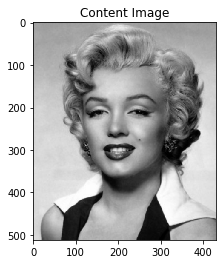

In [9]:
imshow(content_image, 'Content Image')

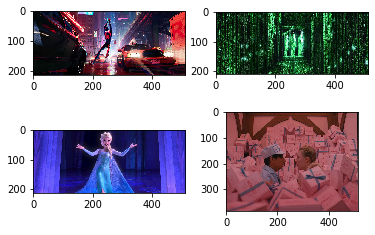

In [10]:
plt.subplot(2, 2, 1)
imshow(style_image_1)

plt.subplot(2, 2, 2)
imshow(style_image_2)

plt.subplot(2, 2, 3)
imshow(style_image_3)

plt.subplot(2, 2, 4)
imshow(style_image_4)

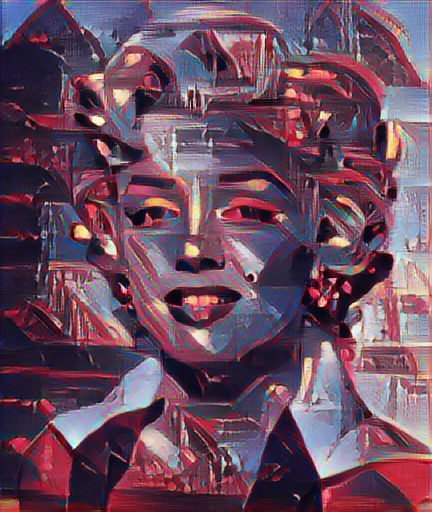

In [11]:
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image_1 = hub_module(tf.constant(content_image), tf.constant(style_image_1))[0]
tensor_to_image(stylized_image_1)

In [12]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 87s 0us/step


TensorShape([1, 1000])

In [13]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 2us/step


[('bikini', 0.21151063),
 ('brassiere', 0.15575275),
 ('hair_spray', 0.112034805),
 ('maillot', 0.08583939),
 ('maillot', 0.083743036)]

In [14]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)

80142336/80134624 [==============================] - 9s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [15]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [16]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

    vgg.trainable = False
  
    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [17]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image_1*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 214, 512, 64)
  min:  0.0
  max:  852.8865
  mean:  23.34084

block2_conv1
  shape:  (1, 107, 256, 128)
  min:  0.0
  max:  4956.375
  mean:  136.0009

block3_conv1
  shape:  (1, 53, 128, 256)
  min:  0.0
  max:  10894.708
  mean:  165.23804

block4_conv1
  shape:  (1, 26, 64, 512)
  min:  0.0
  max:  19446.22
  mean:  664.73645

block5_conv1
  shape:  (1, 13, 32, 512)
  min:  0.0
  max:  4479.9395
  mean:  63.359886



In [18]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [19]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [20]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  50554.45
    mean:  266.7623

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  63534.004
    mean:  8266.15

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  212603.25
    mean:  7407.682

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3059534.5
    mean:  119507.086

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  95281.41
    mean:  937.95996

Contents:
   block5_conv2
    shape:  (1, 32, 26, 512)
    min:  0.0
    max:  1250.4148
    mean:  11.539822


In [21]:
style_targets = extractor(style_image_1)['style']
content_targets = extractor(content_image)['content']

In [22]:
image = tf.Variable(content_image)

In [23]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [24]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [25]:
style_weight=1e-2
content_weight=1e4

In [26]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [27]:
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]

    return x_var, y_var

In [28]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [29]:
tf.image.total_variation(image).numpy()

array([17469.195], dtype=float32)

In [30]:
total_variation_weight=30

In [31]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [32]:
image = tf.Variable(content_image)

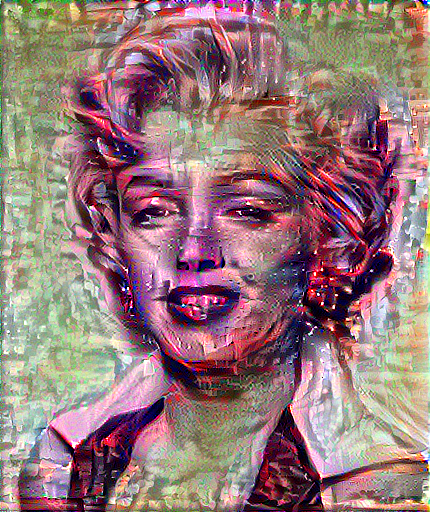

Train step: 100
Total time: 213.1


In [34]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 10

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
        display.clear_output(wait=True)
        display.display(tensor_to_image(image))
        print("Train step: {}".format(step))
    file_name = 'Marilyn_Spiderverse_Epoch_' + str(n) + '.png'
    tensor_to_image(image).save(file_name)

end = time.time()
print("Total time: {:.1f}".format(end-start))

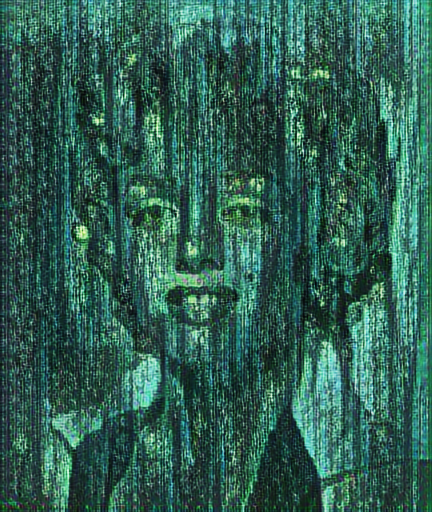

In [35]:
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image_2 = hub_module(tf.constant(content_image), tf.constant(style_image_2))[0]
tensor_to_image(stylized_image_2)

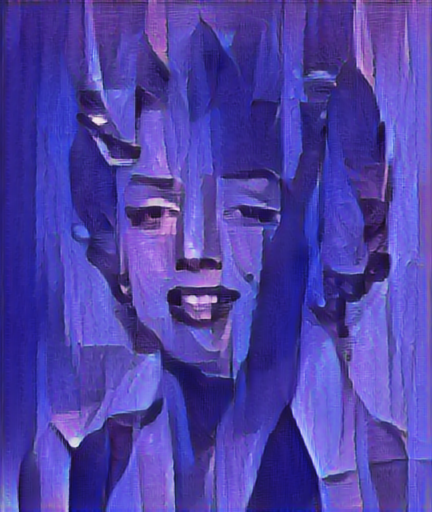

In [36]:
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image_3 = hub_module(tf.constant(content_image), tf.constant(style_image_3))[0]
tensor_to_image(stylized_image_3)

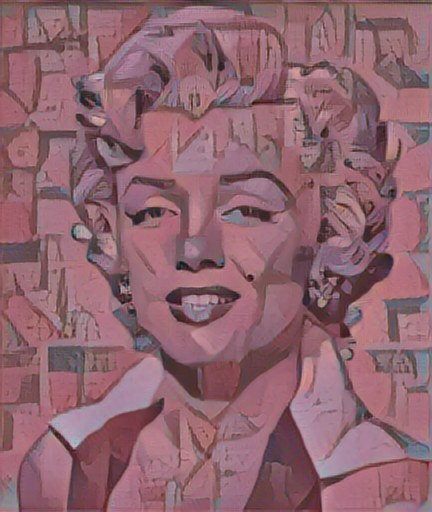

In [37]:
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image_4 = hub_module(tf.constant(content_image), tf.constant(style_image_4))[0]
tensor_to_image(stylized_image_4)

In [48]:
# Source for images:
# https://blogs.getty.edu/iris/getty-artworks-recreated-with-household-items-by-creative-geniuses-the-world-over/
image_1a = load_img(TOP_PATH + '/images/image1_a.png')
image_1b = load_img(TOP_PATH + '/images/image1_b.png')
image_2a = load_img(TOP_PATH + '/images/image2_a.png')
image_2b = load_img(TOP_PATH + '/images/image2_b.png')
image_3a = load_img(TOP_PATH + '/images/image3_a.png')
image_3b = load_img(TOP_PATH + '/images/image3_b.png')

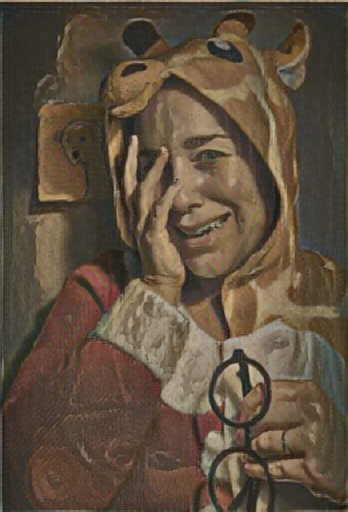

In [49]:
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image_2 = hub_module(tf.constant(image_1b), tf.constant(image_1a))[0]
tensor_to_image(stylized_image_2)

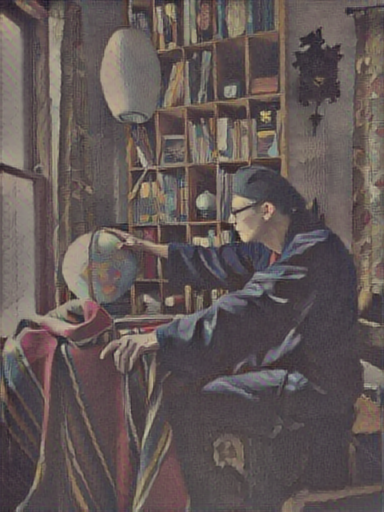

In [50]:
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image_3 = hub_module(tf.constant(image_2b), tf.constant(image_2a))[0]
tensor_to_image(stylized_image_3)

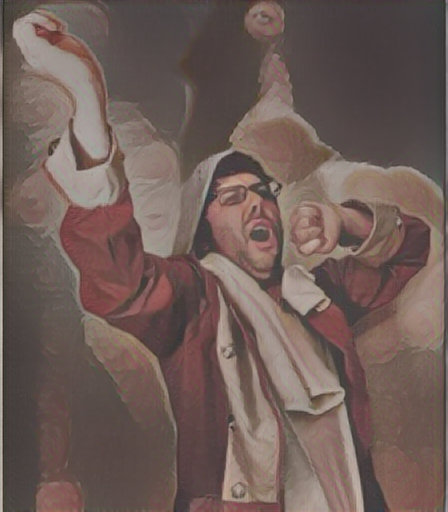

In [52]:
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image_4 = hub_module(tf.constant(image_3b), tf.constant(image_3a))[0]
tensor_to_image(stylized_image_4)